In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry

In [2]:
z500_anoms = xr.open_dataset('/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms/Z500_ERA5.nc')

In [3]:
# region for clustering
lat0=10; lat1=70; lon0=210; lon1=320
z500_anoms_region = z500_anoms.where((z500_anoms.lat>=lat0)&(z500_anoms.lat<=lat1)&\
                   (z500_anoms.lon>=lon0)&(z500_anoms.lon<=lon1),drop=True)

In [4]:
var_name = 'Z_anomalies'

In [5]:
z500_anoms_flattened = z500_anoms_region.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
# z500_anoms_flattened = z500_anoms_flattened.data

# PCA

In [6]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(z500_anoms_flattened)

# transform era5 data with pca
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

Variance explained: [27.62582991 17.23060711 11.94187064  9.20903224  8.26186924  6.47127167
  3.75058     2.53927403  2.29496316  1.83181199  1.53278941  1.02840115]
Cumulative sum of variance explained for EOF1 and EOF2: [27.62582991 44.85643702 56.79830766 66.0073399  74.26920914 80.74048081
 84.49106081 87.03033484 89.325298   91.15711    92.68989941 93.71830056]


# k-means

In [7]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(z500_anoms_transformed)

print(f'inertia: {k_means.inertia_}')

inertia: 21373.893693043152


In [8]:
import joblib

filename = r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230727.mdl'
joblib.dump(pca_obj,filename)

filename = r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230727.mdl'
joblib.dump(k_means,filename)


['/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230727.mdl']

In [9]:
filename = r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230727.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

filename = r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230727.pkl'
pickle.dump(k_means, open(filename, 'wb'))

In [10]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

## load models

In [6]:
import joblib
pca_obj = joblib.load(r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230727.mdl')
k_means = joblib.load(r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230727.mdl')
# data_era5_train = pca_obj.transform(data_era5_train)

In [7]:
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

In [13]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

In [8]:
weather_patterns = k_means.predict(z500_anoms_transformed)

where0 = np.where(weather_patterns==0)
where1 = np.where(weather_patterns==1)
where2 = np.where(weather_patterns==2)
where3 = np.where(weather_patterns==3)

In [9]:
len(weather_patterns)

2073

In [14]:
pd.DataFrame(weather_patterns,index=pd.to_datetime(anomalies_afterPCA.time)).\
    to_csv('/glade/work/jhayron/Data4Predictability/WR_Series.csv')

In [10]:
print('Pattern #0:')
print(np.round(100*len(where0[0])/len(weather_patterns),2))

print('Pattern #1:')
print(np.round(100*len(where1[0])/len(weather_patterns),2))

print('Pattern #2:')
print(np.round(100*len(where2[0])/len(weather_patterns),2))

print('Pattern #3:')
print(np.round(100*len(where3[0])/len(weather_patterns),2))

Pattern #0:
19.59
Pattern #1:
24.12
Pattern #2:
27.5
Pattern #3:
28.8


In [11]:
p0 = np.round(len(where0[0])/len(weather_patterns),2)
p1 = np.round(len(where1[0])/len(weather_patterns),2)
p2 = np.round(len(where2[0])/len(weather_patterns),2)
p3 = np.round(len(where3[0])/len(weather_patterns),2)

In [14]:
anomalies_afterPCA = anomalies_afterPCA / 9.82

In [15]:
mean_wr_0 = anomalies_afterPCA[where0].mean(axis=0)
mean_wr_1 = anomalies_afterPCA[where1].mean(axis=0)
mean_wr_2 = anomalies_afterPCA[where2].mean(axis=0)
mean_wr_3 = anomalies_afterPCA[where3].mean(axis=0)

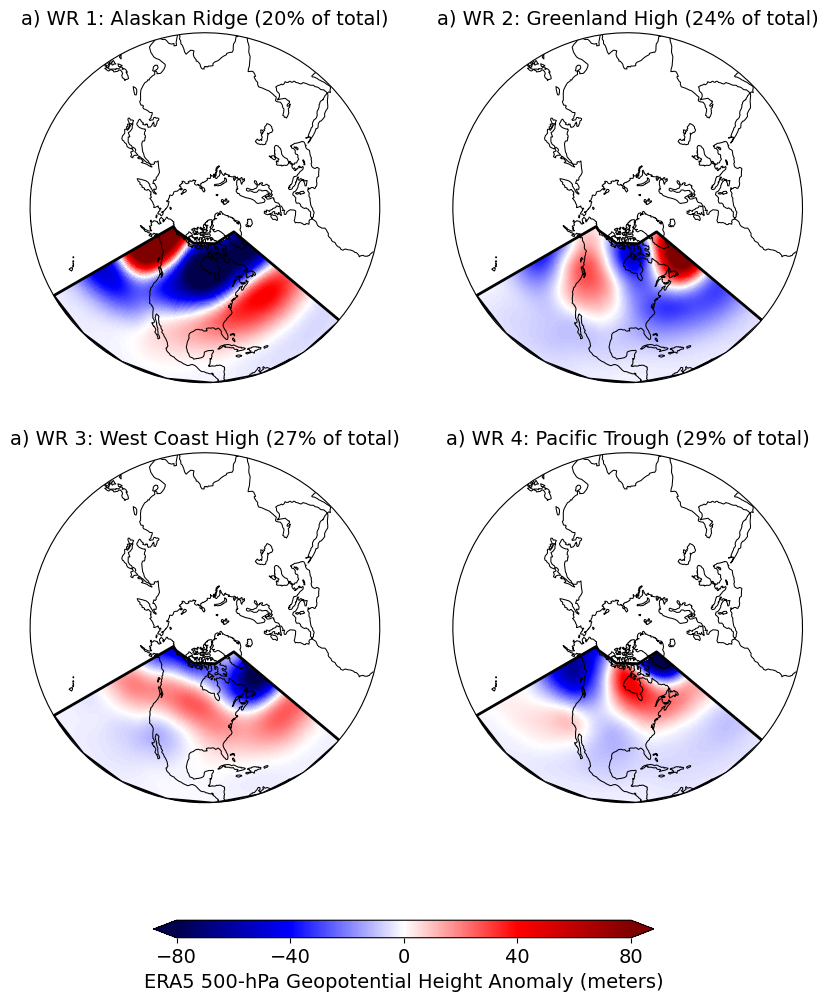

In [17]:
lons, lats = np.meshgrid(anomalies_afterPCA.lon, anomalies_afterPCA.lat)
names = ['Alaskan Ridge','Greenland High','West Coast High', 'Pacific Trough']
arrays = [mean_wr_0,mean_wr_1,mean_wr_2,mean_wr_3]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].pcolormesh(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(),
                         vmin=-80, vmax=80, cmap='seismic')

    axs[indax[0]][indax[1]].set_title(
        f'a) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=2.)
    
# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
# plt.savefig("../../Figures/WR_ERA5_v3.png", bbox_inches='tight', dpi=500)
plt.show()

# ---


In [18]:
mean_wr_0 = z500_anoms.Z_anomalies[where0].mean(axis=0)/9.82
mean_wr_1 = z500_anoms.Z_anomalies[where1].mean(axis=0)/9.82
mean_wr_2 = z500_anoms.Z_anomalies[where2].mean(axis=0)/9.82
mean_wr_3 = z500_anoms.Z_anomalies[where3].mean(axis=0)/9.82

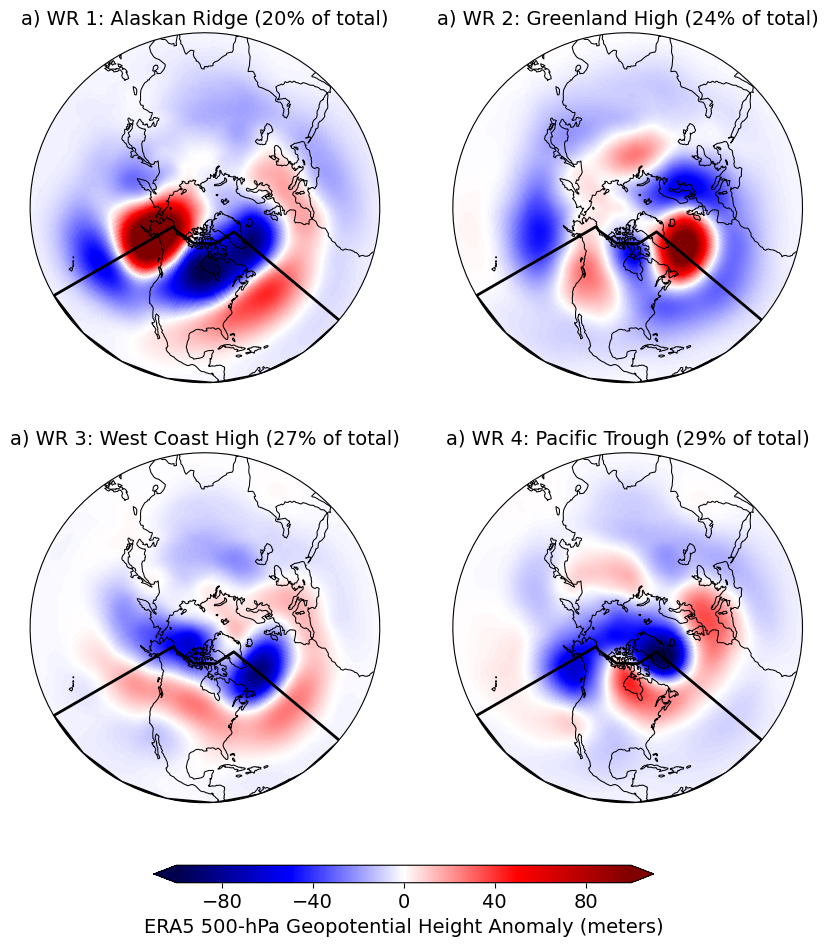

In [25]:
lons, lats = np.meshgrid(z500_anoms.lon, z500_anoms.lat)
names = ['Alaskan Ridge','Greenland High','West Coast High', 'Pacific Trough']
arrays = [mean_wr_0,mean_wr_1,mean_wr_2,mean_wr_3]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].pcolormesh(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(),
                         vmin=-100, vmax=100, cmap='seismic')

    axs[indax[0]][indax[1]].set_title(
        f'a) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=2.)
    
# ---

cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
plt.savefig("WR_ERA5_20230727.png", bbox_inches='tight')
plt.show()

# ---
